In [124]:
import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget
import os, glob


from matplotlib import pyplot
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot


from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
 
from keras.utils import np_utils
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

Using TensorFlow backend.


In [171]:
# Set column dtypes for Pandas
from datetime import datetime
dt = datetime.utcnow()
COLUMN_NAMES = collections.OrderedDict({
  'Gmt time': object,
  'Open': np.float64,
  'High': np.float64,
  'Low': np.float64,
  'Close': np.float64,
  'Volume': np.float64,
  'Open_Bid': np.float64,
  'High_Bid': np.float64,
  'Low_Bid': np.float64,
  'Close_Bid': np.float64,
  'Volume_Bid': np.float64,
  'Spread': np.float64,
  'day_name': object,
  'weekday': 'category',#'category'np.int64
  'Pct_Range_Close': np.float64,
  'Pct_Range_Close_diff': np.float64,
  'MA_Close_5': np.float64,
  'MA_Close_25': np.float64,
  'MA_Close_50': np.float64,
  'MA_Close_200': np.float64,
  'EMA_Close_5': np.float64,
  'Momentum_1': np.float64,
  'Momentum_2': np.float64,
  'Momentum_5': np.float64,
  'Momentum_24': np.float64,
  'rsi': np.float64,
  'Rolling_Mean25': np.float64,
  'Bollinger_High': np.float64,
  'Bollinger_Low': np.float64,
  'PP': np.float64,
  'R1': np.float64,
  'S1': np.float64,
  'R2': np.float64,
  'S2': np.float64,
  'R3': np.float64,
  'S3': np.float64,
  'SO%k': np.float64,
  'SO%k1': np.float64,
  'SO%d2': np.float64,
  'Trix_5': np.float64,
  'MACD_5_25': np.float64,
  'MACDsign_5_25': np.float64,
  'MACDdiff_5_25': np.float64,
  'Mass_Index_25_8_9': np.float64,
  'Class': np.float64
})

In [231]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

3C-EURUSD_FULL_1D_145F.csv
3C-EURUSD_FULL_1D_21F.csv
3C-EURUSD_FULL_1D_45F.csv
3C-EURUSD_FULL_1D_70F.csv
3C-EURUSD_FULL_1H_145F.csv
3C-EURUSD_FULL_1H_45F.csv
3C-EURUSD_FULL_1H_70F.csv
5C-EURUSD_FULL_1D_21F.csv
5C-EURUSD_FULL_1D_45F.csv
C-EURUSD_FULL_1D_21F.csv
C-EURUSD_FULL_1H_25F.csv
C-EURUSD_FULL_1H_45F.csv
C-EURUSD_FULL_1H_54F.csv


In [232]:
#SELECT an INDEX 
INDX = 0

CLASS_NUMBER = '3C'
MODEL_TYPE = 'XGBOOST'
FRECUENCIA = '1D'
TARGET_NAME = "Class"
ID = '06'

RANGE = 0
TEST_SIZE = .25
VAL_SIZE = .20

In [233]:
# Load data into Pandas
data = pd.read_csv(filenames[INDX], 
  index_col=False,
  dtype=COLUMN_NAMES
)
data = data.dropna()

#data = shuffle(data, random_state=2)
data.head()

,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,Class
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,...,76.440177,76.440177,-23.559823,0.0,1.257330,0.0,-0.522913,0.000000,0.000000,0.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,...,71.590909,74.015543,-28.409091,0.0,1.257865,0.0,0.078738,0.078707,0.078738,1.0
2,2004-01-04,1.25925,1.26487,1.25789,1.26318,6.879980e+04,1.25855,1.26477,1.25779,1.26308,...,90.553382,79.528156,-9.446618,0.0,1.260854,0.0,0.386229,0.385485,0.465272,1.0
3,2004-01-05,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.26308,1.26924,1.26288,1.26820,...,95.306214,85.816835,-4.693786,0.0,1.265002,0.0,0.405326,0.404507,0.872484,1.0
4,2004-01-06,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.26820,1.28083,1.26650,1.27140,...,72.223859,86.027818,-27.776141,0.0,1.268630,0.0,0.252306,0.251988,1.126991,-1.0


In [234]:
data.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Bid',
       'High_Bid', 'Low_Bid', 'Close_Bid',
       ...
       'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao',
       'momentum_kama', 'momentum_roc', 'others_dr', 'others_dlr', 'others_cr',
       'Class'],
      dtype='object', length=145)

In [235]:
data = data.drop(['Gmt time'], axis = 1)
data = data.drop(['day_name'], axis = 1)
data = data.drop(['weekday'], axis = 1)
data = data.drop(['Open_Bid'], axis = 1)
data = data.drop(['High_Bid'], axis = 1)
data = data.drop(['Low_Bid'], axis = 1)
data = data.drop(['Close_Bid'], axis = 1)

#data = data.drop(['PP'], axis = 1)
#data = data.drop(['R1'], axis = 1)
#data = data.drop(['R2'], axis = 1)
#data = data.drop(['R3'], axis = 1)
#data = data.drop(['S1'], axis = 1)
#data = data.drop(['S2'], axis = 1)
#data = data.drop(['S3'], axis = 1)

data = data.drop(['EMA_Close_5'], axis = 1)

data.head()

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,Class
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,76.440177,76.440177,-23.559823,0.0,1.257330,0.0,-0.522913,0.000000,0.000000,0.0
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,71.590909,74.015543,-28.409091,0.0,1.257865,0.0,0.078738,0.078707,0.078738,1.0
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,90.553382,79.528156,-9.446618,0.0,1.260854,0.0,0.386229,0.385485,0.465272,1.0
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,95.306214,85.816835,-4.693786,0.0,1.265002,0.0,0.405326,0.404507,0.872484,1.0
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,72.223859,86.027818,-27.776141,0.0,1.268630,0.0,0.252306,0.251988,1.126991,-1.0


In [236]:
SIZE = data.shape[0]
NUM_FEATURES = data.shape[1]
print(SIZE)
print(NUM_FEATURES)

5137
137


In [237]:
#LOCATION TO SAVE
pwd = os.getcwd()
source_data_toSave = os.path.join(pwd, r'../../../Models/2020/XGBoost/')
#print('Location to Save: ', source_data)
FILENAME = CLASS_NUMBER + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + str(SIZE) + 'Size_' + MODEL_TYPE +  '_' + TARGET_NAME + "_"+ ID 
file_name_toSave = FILENAME + '.bst'
print('FILENAME: ', FILENAME)
print('File Name Model:', file_name_toSave)

FILENAME:  3C_1D_137F_5137Size_XGBOOST_Class_06
File Name Model: 3C_1D_137F_5137Size_XGBOOST_Class_06.bst


In [238]:
full_dataset_results_csv = os.path.join(pwd, r'../../../Results/XGBoost/' + FILENAME + '_Full.csv')
print(full_dataset_results_csv)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Results/XGBoost/3C_1D_137F_5137Size_XGBOOST_Class_06_Full.csv


In [239]:
# Label preprocessing
labels = data['Class'].values

#generate the VECTOR Y
uniques, ids = np.unique(labels, return_inverse=True)
target_y = np_utils.to_categorical(ids,len(uniques))
print(ids)
print(uniques)
print(target_y)
labels = target_y
# See the distribution of approved / denied classes (0: denied, 1: approved)
print(data['Class'].value_counts())

[1 2 2 ... 2 1 1]
[-1.  0.  1.]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
 1.0    1729
 0.0    1716
-1.0    1692
Name: Class, dtype: int64


In [240]:
data = data.drop(columns=['Class'])

In [241]:
def get_2Dimension(df, RANGE):
    new_df = pd.DataFrame()
    for i in range(RANGE):
#        new_df = df
        for j in range (df.shape[1]):
            #value = df.iloc[i+1,j]
            #print(value)
            new_col_name = df.columns[j] + '_' + str(i+1)
            #print(new_col_name)
            new_df[new_col_name] = df.iloc[i+1:,j]
            #print(new_df[new_col_name].isnull().sum())
            new_df.fillna(method='backfill', inplace=True)
            #print(new_df[new_col_name].isnull().sum())
    print(new_df.columns)
    return new_df

 


In [242]:
data

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,0.000000,76.440177,76.440177,-23.559823,0.000000,1.257330,0.000000,-0.522913,0.000000,0.000000
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,25.516102,71.590909,74.015543,-28.409091,0.000000,1.257865,0.000000,0.078738,0.078707,0.078738
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,36.762821,90.553382,79.528156,-9.446618,0.000000,1.260854,0.000000,0.386229,0.385485,0.465272
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,44.645711,95.306214,85.816835,-4.693786,0.000000,1.265002,0.000000,0.405326,0.404507,0.872484
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,41.690793,72.223859,86.027818,-27.776141,0.000000,1.268630,0.000000,0.252306,0.251988,1.126991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132,1.09019,1.09960,1.08970,1.09787,2.219154e+05,2.075363e+05,0.00003,0.007045,0.007631,2.134402e+09,...,53.470734,87.194861,66.181299,-12.805139,0.005839,1.090343,1.224426,0.704464,0.701995,-12.682430
5133,1.09788,1.10311,1.09342,1.10169,3.392159e+05,3.194905e+05,0.00003,0.003479,-0.003565,2.134742e+09,...,60.537067,94.453125,78.650685,-5.546875,0.005649,1.092116,1.806605,0.347946,0.347343,-12.378612
5134,1.10168,1.10937,1.09919,1.10782,2.907155e+05,2.312052e+05,0.00003,0.005564,0.002085,2.135032e+09,...,63.147537,95.134965,92.260984,-4.865035,0.007610,1.095113,2.515176,0.556418,0.554876,-11.891071
5135,1.10780,1.11452,1.10702,1.11071,3.306924e+05,3.730174e+05,0.00035,0.002609,-0.002955,2.135363e+09,...,66.774381,89.705485,93.097858,-10.294515,0.011013,1.097529,2.655317,0.260873,0.260533,-11.661219


In [243]:
pd_old_rows = get_2Dimension(data,RANGE)

Index([], dtype='object')


In [244]:
pd_old_rows.shape

(0, 0)

In [245]:
data = pd.concat([data, pd_old_rows], axis=1, sort=False)
data.fillna(method='backfill', inplace=True)
data.shape

(5137, 136)

In [246]:
data.head(10)

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,0.000000,76.440177,76.440177,-23.559823,0.000000,1.257330,0.0,-0.522913,0.000000,0.000000
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,25.516102,71.590909,74.015543,-28.409091,0.000000,1.257865,0.0,0.078738,0.078707,0.078738
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,36.762821,90.553382,79.528156,-9.446618,0.000000,1.260854,0.0,0.386229,0.385485,0.465272
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,44.645711,95.306214,85.816835,-4.693786,0.000000,1.265002,0.0,0.405326,0.404507,0.872484
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,41.690793,72.223859,86.027818,-27.776141,0.000000,1.268630,0.0,0.252306,0.251988,1.126991
5,1.27161,1.27417,1.26180,1.26377,1.111343e+06,1.345833e+06,0.00010,-0.006079,-0.008602,4.954033e+06,...,36.724836,49.455081,72.328384,-50.544919,0.001936,1.266511,0.0,-0.607943,-0.609799,0.512196
6,1.26369,1.27854,1.25590,1.27696,1.115933e+06,1.348588e+06,0.00010,0.010437,0.016516,6.069966e+06,...,51.405206,88.306333,69.995091,-11.693667,0.003342,1.270900,0.0,1.043703,1.038294,1.561245
7,1.27698,1.28676,1.27034,1.28149,1.066698e+06,1.274568e+06,0.00026,0.003547,-0.006890,7.136664e+06,...,58.689798,86.752137,74.837850,-13.247863,0.004954,1.275085,0.0,0.354749,0.354121,1.921532
8,1.28279,1.28572,1.28253,1.28477,7.567420e+04,8.780950e+04,0.00010,0.002560,-0.000988,7.212338e+06,...,59.848956,94.997486,90.018652,-5.002514,0.006506,1.278809,0.0,0.255952,0.255625,2.182402
9,1.28498,1.28971,1.27327,1.27390,1.110720e+06,1.341147e+06,0.00010,-0.008461,-0.011020,8.323059e+06,...,50.366111,63.000234,81.583286,-36.999766,0.006679,1.277300,0.0,-0.846066,-0.849665,1.317872


In [247]:
# Convert categorical columns to dummy columns
dummy_columns = list(data.dtypes[data.dtypes == 'category'].index)
data = pd.get_dummies(data, columns=dummy_columns)

In [248]:
# Preview the data
data.head()

,Open,High,Low,Close,Volume,Volume_Bid,Spread,Pct_Range_Close,Pct_Range_Close_diff,AQV,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,1.25950,1.26052,1.24698,1.25733,4.621817e+05,5.597896e+05,0.00010,0.000000,0.000000,4.621817e+05,...,0.000000,76.440177,76.440177,-23.559823,0.0,1.257330,0.0,-0.522913,0.000000,0.000000
1,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.277971e+06,0.00026,0.000787,0.000787,1.528760e+06,...,25.516102,71.590909,74.015543,-28.409091,0.0,1.257865,0.0,0.078738,0.078707,0.078738
2,1.25925,1.26487,1.25789,1.26318,6.879980e+04,8.372040e+04,0.00010,0.003862,0.003075,1.597559e+06,...,36.762821,90.553382,79.528156,-9.446618,0.0,1.260854,0.0,0.386229,0.385485,0.465272
3,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.353480e+06,0.00010,0.004053,0.000191,2.717248e+06,...,44.645711,95.306214,85.816835,-4.693786,0.0,1.265002,0.0,0.405326,0.404507,0.872484
4,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.354807e+06,0.00010,0.002523,-0.001530,3.842691e+06,...,41.690793,72.223859,86.027818,-27.776141,0.0,1.268630,0.0,0.252306,0.251988,1.126991


In [249]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Bid', 'Spread',
       'Pct_Range_Close', 'Pct_Range_Close_diff', 'AQV',
       ...
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_kama', 'momentum_roc', 'others_dr',
       'others_dlr', 'others_cr'],
      dtype='object', length=136)

In [250]:
# Split the data into train / test sets
x,y = data,labels
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [251]:
print(x.shape)
print(y)

(5137, 136)
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [263]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

param = {'max_depth': '6', 'objective':'multi:softprob', 
         'tree_method':'hist', 'num_class': 3,
         'eval_metric': 'mlogloss'}

bst_cust = xgb.train(param, dtrain, num_boost_round=100, 
                     verbose_eval=10)


[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/common/hist_util.cc:134: Building quantile cut on a dense dataset or distributed environment.
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/common/hist_util.cc:138: Total number of hist bins: 32375
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes,

[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[00:57:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[00:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes

[00:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[00:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[00:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[00:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[00:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:57:38] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a si

[00:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[00:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[00:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[00:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[00:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[00:57:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 100 ex

[00:57:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[00:57:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:57:40] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[00:57:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[00:57:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[00:57:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:57:40] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a sing

[00:57:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[00:57:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[00:57:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:57:41] INFO: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:169: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[00:57:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[00:57:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[00:57:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 0 extra nodes, 0 pruned nodes

In [265]:
preds=bst_cust.predict(dtest)
preds[:20]

array([[8.54194164e-01, 1.45781651e-01, 2.41489051e-05],
       [8.69474769e-01, 1.30501509e-01, 2.37863514e-05],
       [8.48833323e-01, 1.51141346e-01, 2.53580492e-05],
       [7.60412753e-01, 2.39559516e-01, 2.77262934e-05],
       [8.67207229e-01, 1.32774234e-01, 1.85565987e-05],
       [2.10346580e-01, 7.89627850e-01, 2.55774376e-05],
       [9.94853556e-01, 5.13972528e-03, 6.71032785e-06],
       [6.59547389e-01, 3.40414494e-01, 3.80999518e-05],
       [7.93163717e-01, 2.06814244e-01, 2.20189304e-05],
       [6.47422194e-01, 3.52541804e-01, 3.59935293e-05],
       [7.84375846e-01, 2.15597093e-01, 2.70392920e-05],
       [6.61955297e-01, 3.38016599e-01, 2.81049925e-05],
       [6.12004161e-01, 3.87959510e-01, 3.63246254e-05],
       [5.25184870e-01, 4.74779993e-01, 3.51572962e-05],
       [7.59468973e-01, 2.40504086e-01, 2.69292450e-05],
       [8.84178758e-01, 1.15802675e-01, 1.86145371e-05],
       [6.60389721e-01, 3.39577377e-01, 3.28721108e-05],
       [9.63835359e-01, 3.61508

In [254]:
# Train the model, this will take a few minutes to run
param = {'max_depth': '6', 'objective':'multi:softprob', 
         'tree_method':'hist', 'num_class': 3,
         'eval_metric': 'mlogloss'}

bst = xgb.XGBClassifier(
    params,
    #objective='reg:logistic',
    verbosity=2,
    max_depth=8,
)

bst.fit(x_train, y_train)

ValueError: y should be a 1d array, got an array of shape (3852, 3) instead.

In [50]:
# Save the model so we can deploy it
#bst.save_model(source_data_toSave + file_name_toSave)

In [51]:
#bst_loaded = xgb.Booster({'nthread': 4})  # init model
#bst_loaded.load_model(source_data_toSave + file_name_toSave)  # load data

In [229]:
# Get predictions on the test set and print the accuracy score
y_pred = bst.predict(x_test)
y_pred

array([1., 1., 0., ..., 0., 1., 0.])

In [230]:
acc = accuracy_score(y_test, y_pred.round())
print(acc, '\n')

0.4178988326848249 



In [215]:
uniques_1 = [-1,0,1]
uniques_1

[-1, 0, 1]

In [218]:
uniques_y_test, ids_y_test = np.unique(y_test, return_inverse=True)
y_test_categorical = np_utils.to_categorical(ids_y_test,len(uniques_1))
y_test_categorical

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [219]:
uniques, ids = np.unique(y_pred, return_inverse=True)
y_pred_categorical = np_utils.to_categorical(ids,len(uniques_1))
y_pred_categorical

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [197]:
uniques_y_test_pred = uniques[y_pred_categorical.argmax(1)]
uniques_y_test_pred

array([-1.,  1.,  0., ...,  0.,  0., -1.])

In [203]:
# Print a confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)

Confusion matrix:
[[0.35903614 0.28743961 0.32236842]
 [0.25542169 0.49275362 0.22807018]
 [0.37831325 0.29227053 0.39035088]]


In [204]:
def precision(label, confusion_matrix):
    #print('label',label)
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [205]:
conf_matrix_test = confusion_matrix(y_test, y_pred)
conf_matrix_test

array([[149, 119, 147],
       [106, 204, 104],
       [157, 121, 178]])

In [206]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_test):9.3f}    {recall(indx, conf_matrix_test):6.3f}")

indx Value Precision Recall
0
   -1        0.362     0.359
1
    0        0.459     0.493
2
    1        0.415     0.390


In [207]:
print("precision total:", precision_macro_average(conf_matrix_test))
print("recall total:", recall_macro_average(conf_matrix_test))

precision total: 0.4120094532715892
recall total: 0.41404688165323383


In [209]:

# Binarize the output
y = label_binarize(y_test, classes=[-1, 0, 1])
n_classes = y.shape[1]
n_classes

3

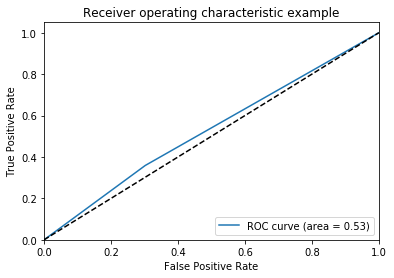

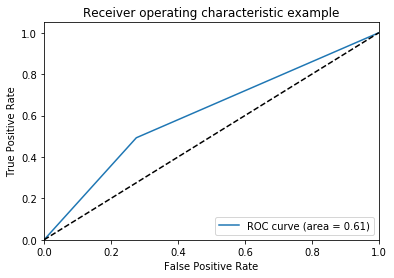

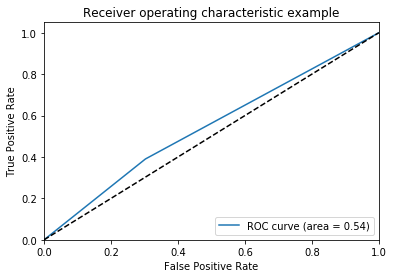

In [212]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc





# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:,i], y_pred_categorical[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [112]:
y_test.ravel()[:20]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
      dtype=int64)

/Users/marami3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


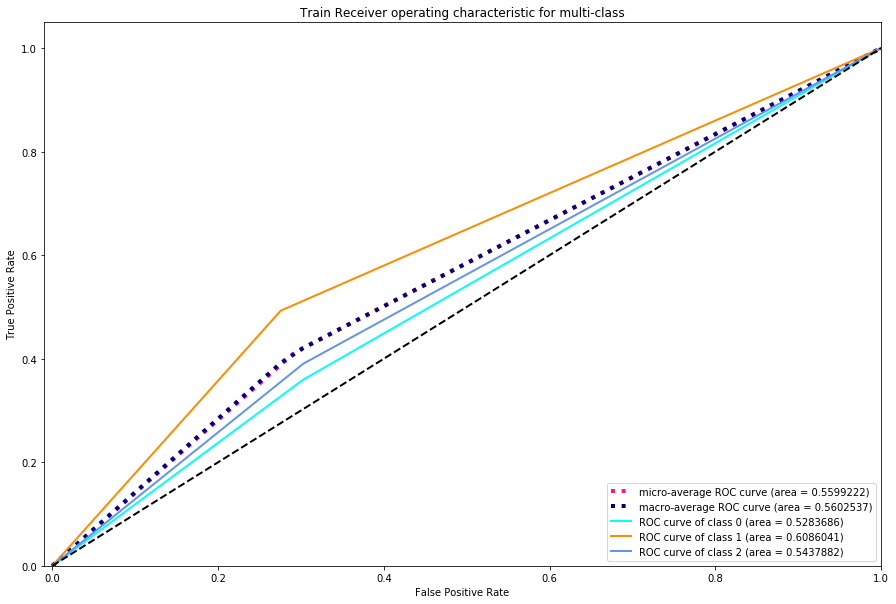

In [214]:
y_pred_categorical
y_test_categorical

from scipy import interp
from itertools import cycle
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_pred_categorical[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(decodedTestY, decodedTestPredict)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_categorical.ravel(), y_pred_categorical.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test_categorical.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_test_categorical.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= y_test_categorical.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=[15,10])
#plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','magenta'])
for i, color in zip(range(y_test_categorical.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.7f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

[0.02732106 0.03273106 0.04072278 0.04040572 0.03540054 0.03325282
 0.06740314 0.03104635 0.03183758 0.0353444  0.03710331 0.03684867
 0.04178809 0.03481425 0.03207485 0.03204281 0.03163839 0.02999826
 0.0366594  0.03778411 0.04362586 0.03080664 0.         0.02989509
 0.03108581 0.03603786 0.03732575 0.03331617 0.03168931]


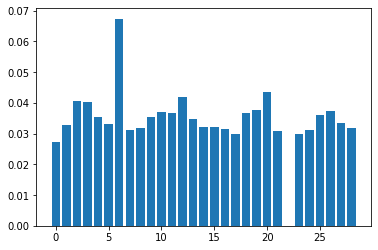

In [188]:

print(bst.feature_importances_)
pyplot.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
pyplot.show()

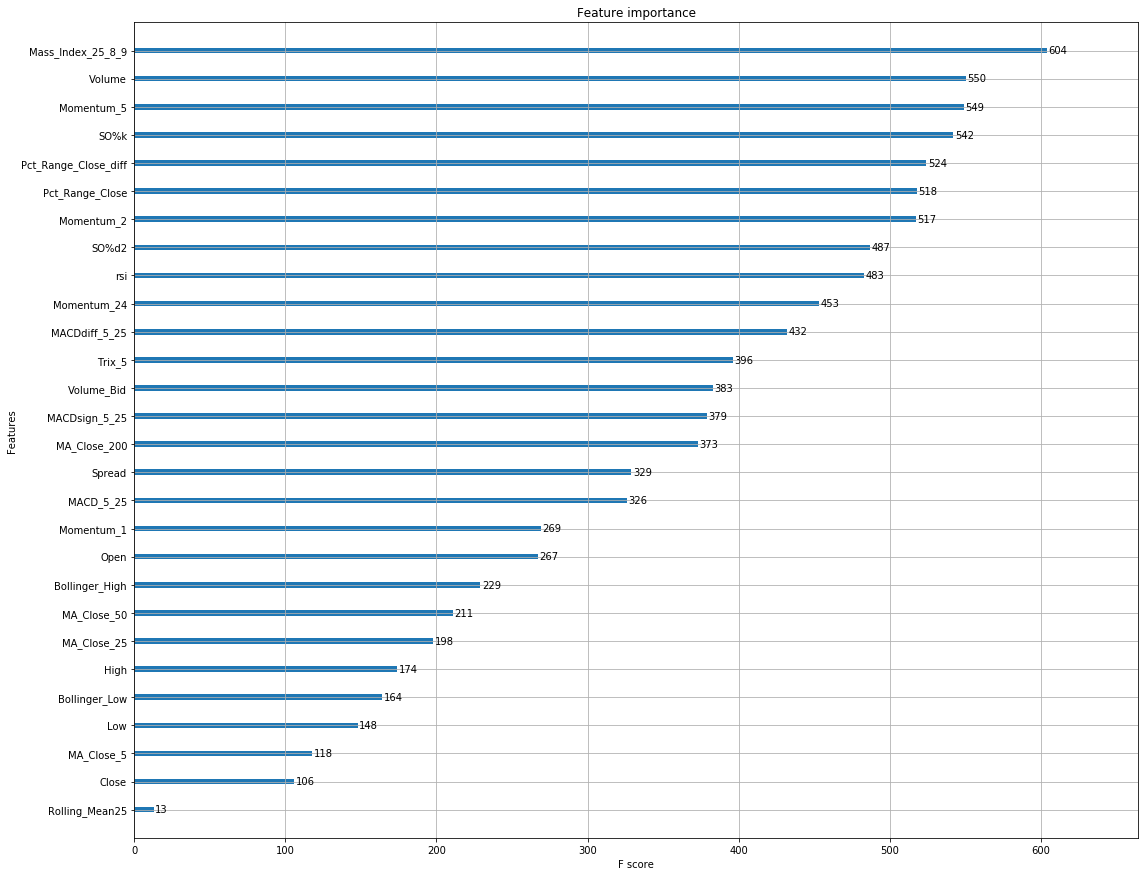

In [189]:


# plot feature importance

ax = plot_importance(bst)
fig = ax.figure
fig.set_size_inches(18, 15)
pyplot.show()

In [24]:
# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None
 
# split data into X and y
x,y = data,labels
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=7)
# fit model on all training data
model = MyXGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, Accuracy: 39.80%
Thresh=0.000, n=87, A

In [190]:
yhat = bst.predict(x)

In [191]:
y_real = pd.DataFrame({'Real_Class': y})
yhat_pd = pd.DataFrame({'Predicted_Class': yhat})
print(y_real)
print(yhat_pd)

      Real_Class
0            0.0
1            1.0
2            1.0
3            1.0
4           -1.0
...          ...
5132         1.0
5133         1.0
5134         1.0
5135         0.0
5136         0.0

[5137 rows x 1 columns]
      Predicted_Class
0                 1.0
1                 1.0
2                 1.0
3                 1.0
4                -1.0
...               ...
5132              1.0
5133              1.0
5134              1.0
5135              0.0
5136              0.0

[5137 rows x 1 columns]


In [192]:
x_real = pd.concat([x,y_real], axis=1, sort=False)
print(x_real.shape)
print(x_real.head)

(5137, 30)
<bound method NDFrame.head of          Open     High      Low    Close        Volume    Volume_Bid   Spread  \
0     1.25950  1.26052  1.24698  1.25733  4.621817e+05  5.597896e+05  0.00010   
1     1.25717  1.26282  1.25214  1.25832  1.066578e+06  1.277971e+06  0.00026   
2     1.25925  1.26487  1.25789  1.26318  6.879980e+04  8.372040e+04  0.00010   
3     1.26324  1.26935  1.26301  1.26830  1.119689e+06  1.353480e+06  0.00010   
4     1.26836  1.28093  1.26666  1.27150  1.125442e+06  1.354807e+06  0.00010   
...       ...      ...      ...      ...           ...           ...      ...   
5132  1.09019  1.09960  1.08970  1.09787  2.219154e+05  2.075363e+05  0.00003   
5133  1.09788  1.10311  1.09342  1.10169  3.392159e+05  3.194905e+05  0.00003   
5134  1.10168  1.10937  1.09919  1.10782  2.907155e+05  2.312052e+05  0.00003   
5135  1.10780  1.11452  1.10702  1.11071  3.306924e+05  3.730174e+05  0.00035   
5136  1.11213  1.11217  1.11028  1.11158  1.012642e+04  9.217483e+03

In [193]:
x_full1 = pd.concat([x_real,yhat_pd], axis=1, sort=False)
print(x_full1.shape)
print(x_full1.head)

(5137, 31)
<bound method NDFrame.head of          Open     High      Low    Close        Volume    Volume_Bid   Spread  \
0     1.25950  1.26052  1.24698  1.25733  4.621817e+05  5.597896e+05  0.00010   
1     1.25717  1.26282  1.25214  1.25832  1.066578e+06  1.277971e+06  0.00026   
2     1.25925  1.26487  1.25789  1.26318  6.879980e+04  8.372040e+04  0.00010   
3     1.26324  1.26935  1.26301  1.26830  1.119689e+06  1.353480e+06  0.00010   
4     1.26836  1.28093  1.26666  1.27150  1.125442e+06  1.354807e+06  0.00010   
...       ...      ...      ...      ...           ...           ...      ...   
5132  1.09019  1.09960  1.08970  1.09787  2.219154e+05  2.075363e+05  0.00003   
5133  1.09788  1.10311  1.09342  1.10169  3.392159e+05  3.194905e+05  0.00003   
5134  1.10168  1.10937  1.09919  1.10782  2.907155e+05  2.312052e+05  0.00003   
5135  1.10780  1.11452  1.10702  1.11071  3.306924e+05  3.730174e+05  0.00035   
5136  1.11213  1.11217  1.11028  1.11158  1.012642e+04  9.217483e+03

In [196]:
#Save
x_full1.to_csv(full_dataset_results_csv, header=True, index=False)